# **Bayesian Machine Learning Summer Camp (ICAS - UNSAM)**

#### Infering lens mass parameters with Convolutional Neural Networks (CNN)



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras import datasets, layers, models
import json
from google.colab import drive
from google.colab import files

!pip install gdown
!pip install deeplenstronomy
np.random.seed(42)

from deeplenstronomy.visualize import view_image


# Mount google drive and download the files

It may ask your permission to access your g-drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Check if the data is already in your folder. If it is not, download it
!ls
import os.path
if os.path.exists("LSST_nobackground"):
   %cd lensdata
   !ls
else:
   !gdown --no-check-certificate --folder https://drive.google.com/drive/folders/1lH7KqxwjgXqtpjwp0qIdnaKXySUrIgDS?usp=sharing

drive  LSST_nobackground  sample_data
[Errno 2] No such file or directory: 'lensdata'
/content
drive  LSST_nobackground  sample_data


In [4]:
# The data we will be using is given by a metadata (.csv) file with true (actual) lens mass parameters from simulations and the images in an npy format
# Here, we set the paths for both files
dataset_path = "./LSST_nobackground"
metadata_file = "CONFIGURATION_1_metadata.csv"
images_file = "CONFIGURATION_1_images.npy"

metadata_path = os.path.join(dataset_path, metadata_file)
images_path = os.path.join(dataset_path, images_file)

In [5]:
# Reading the metadata file
metadata = pd.read_csv(metadata_path)
# Selecting only the lens mass parameters we are going to use: Einstein radius, lens mass excentricities and shear components
metadata = metadata[["PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g", "PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g", "PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g", "PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma1-g", "PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma2-g"]]
metadata.head()

,PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g,PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g,PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g,PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma1-g,PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma2-g
0,2.704500,0.070226,-0.017787,0.045848,0.025282
1,2.591444,0.243610,0.672743,-0.041613,-0.017017
2,0.550249,-0.170348,-0.325661,0.048350,0.002656
3,2.535891,-0.078315,-0.473699,-0.029534,-0.085650
4,1.110033,0.002495,-0.105262,-0.033977,0.072997


In [6]:
# Reading our astronomical images
images = np.load(images_path)

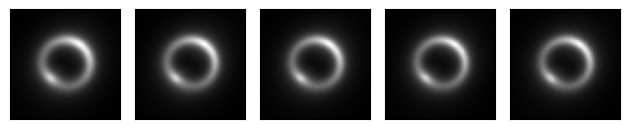

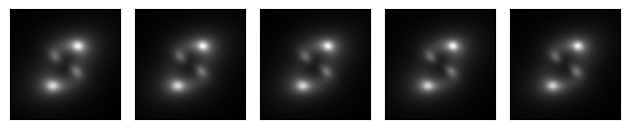

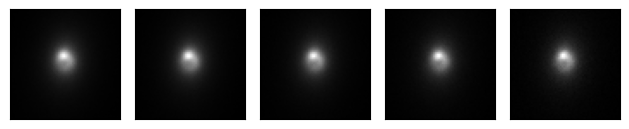

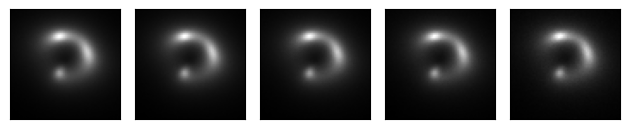

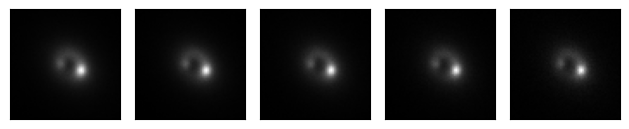

In [20]:
# Visualizing our images:
for i in range(0, 5):
    view_image(images[i], cmap='gray')

In [8]:
# Split our data in training and test dataset with ratio 90 - 10 %
metadata_train, metadata_test = train_test_split(metadata, test_size=0.1)
print(f"Training dataset length: {len(metadata_train)}")
print(f"Test dataset length: {len(metadata_test)}")

Training dataset length: 2249
Test dataset length: 250


In [9]:
# Split our data into training, validation, and test datasets.
np.random.seed(42)
metadata_train, metadata_val = train_test_split(metadata_train, test_size=0.1)
print(f"Training dataset length: {len(metadata_train)}")
print(f"Validation dataset length: {len(metadata_val)}")
print(f"Test dataset length: {len(metadata_test)}")

Training dataset length: 2024
Validation dataset length: 225
Test dataset length: 250


In [10]:
# Select the images according to the training, validation, and test datasets indexes in the metadata dataframe and converts to numpy arrays
x_train = images[metadata_train.index.values]
y_train = np.array(metadata_train)

x_val = images[metadata_val.index.values]
y_val = np.array(metadata_val)

x_test = images[metadata_test.index.values]
y_test = np.array(metadata_test)

# Move axis in order to train our machine learning model. At the end, we want to have an imput array of images with shape of (N, 64, 64, 5) (N, axis, axis, bands)
x_train = np.moveaxis(x_train, 1, 2)
x_train = np.moveaxis(x_train, 3, 2)

x_test = np.moveaxis(x_test, 1, 2)
x_test = np.moveaxis(x_test, 3, 2)

x_val = np.moveaxis(x_val, 1, 2)
x_val = np.moveaxis(x_val, 3, 2)

In [11]:
# Our CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3),input_shape=(64, 64, 5),use_bias=False))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Conv2D(64, (3, 3) ,use_bias=False))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Conv2D(64, (3, 3),use_bias=False))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5,activation='linear'))

In [12]:
# Summary of the Netwoork: with layers, shapes and number of parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        1440      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 31, 31, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18432     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0

In [13]:
# Here we compile the model, setting the optimizer, the loss and the metrics during the training process
model.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error',
    metrics=['mse', 'mae', 'mape']
)
gen = tf.keras.preprocessing.image.ImageDataGenerator()
batch_size=32
start = time.perf_counter()
generator = gen.flow(x_train, y_train, batch_size = batch_size)
# Training our CNN
history = model.fit_generator(
    generator,
    steps_per_epoch=len(x_train)/batch_size,
    epochs=30,
    validation_data = (x_val, y_val),
    validation_steps = len(x_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]

)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2024, 64, 64, 5) (5 channels).
  warnings.warn(
<ipython-input-13-680ec8dac877>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


63/63 [==============================] - 20s 35ms/step - loss: 0.2436 - mse: 0.2436 - mae: 0.2766 - mape: 1378.2903 - val_loss: 0.2570 - val_mse: 0.2570 - val_mae: 0.2968 - val_mape: 592.1296
Epoch 2/30
63/63 [==============================] - 1s 19ms/step - loss: 0.0528 - mse: 0.0528 - mae: 0.1580 - mape: 457.2334 - val_loss: 0.1635 - val_mse: 0.1635 - val_mae: 0.2370 - val_mape: 241.7293
Epoch 3/30
63/63 [==============================] - 1s 22ms/step - loss: 0.0409 - mse: 0.0409 - mae: 0.1420 - mape: 393.1547 - val_loss: 0.0737 - val_mse: 0.0737 - val_mae: 0.1828 - val_mape: 631.4460
Epoch 4/30
63/63 [==============================] - 1s 22ms/step - loss: 0.0369 - mse: 0.0369 - mae: 0.1363 - mape: 499.8679 - val_loss: 0.0605 - val_mse: 0.0605 - val_mae: 0.1653 - val_mape: 298.5143
Epoch 5/30
63/63 [==============================] - 2s 28ms/step - loss: 0.0352 - mse: 0.0352 - mae: 0.1328 - mape: 367.4041 - val_loss: 0.0443 - val_mse: 0.0443 - val_mae: 0.1434 - val_mape: 314.3933
Epoc

# **Test your Knowledge! 💻**

1.   Run this notebook;

2.   Create a matplotlib plot to visualize the training and validation set *loss* per *epoch*.

3.   Generate a matplotlib plot to compare true parameters with predicted values.

4.   Compute the mean discrepancy of the parameters on the test dataset.

  a.   Why is the mean squared error of $\theta_E$  typically smaller than the others


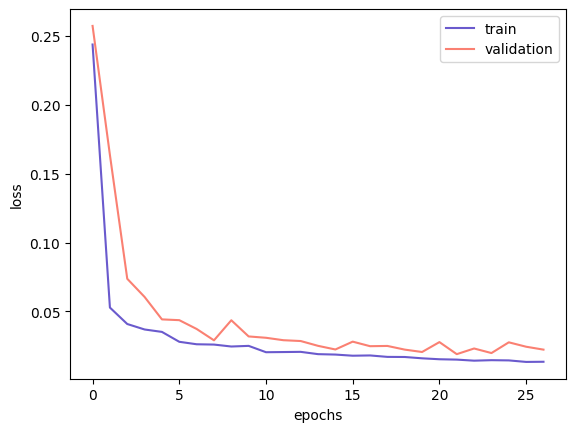

In [14]:
plt.plot(history.history['loss'], label='train', c='slateblue')
plt.plot(history.history['val_loss'], label='validation', c='salmon')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

In [15]:
results = np.squeeze(model.predict(x_test)).T

8/8 [==============================] - 0s 25ms/step


In [16]:
results = pd.DataFrame(np.array([metadata_test.index.values, results[0], y_test.T[0], results[1], y_test.T[1], results[2], y_test.T[2], results[3], y_test.T[3], results[4], y_test.T[4]]).T, columns=['sys', 'theta_e_pred', 'theta_e_true', 'e1_pred', 'e1_true', 'e2_pred', 'e2_true', 'shear1_pred', 'shear1_true', 'shear2_pred', 'shear2_true'])
results.head()

,sys,theta_e_pred,theta_e_true,e1_pred,e1_true,e2_pred,e2_true,shear1_pred,shear1_true,shear2_pred,shear2_true
0,2319.0,2.115694,2.186642,-0.180652,-0.389663,0.027127,-0.026990,-0.033800,0.014423,-0.010080,-0.026893
1,1865.0,2.688825,2.971209,0.377431,0.335061,-0.080166,-0.126354,-0.049612,-0.108784,-0.073418,-0.022423
2,902.0,1.069270,1.224451,0.222821,0.343002,-0.052864,-0.075432,-0.034248,-0.051555,-0.017526,0.006301
3,2240.0,0.313226,0.783697,0.184534,0.115936,0.036676,0.344189,-0.004489,0.019194,-0.051167,0.040993
4,1285.0,1.079963,1.138481,0.034057,0.285717,0.065961,0.304224,-0.065186,0.018476,-0.021580,0.005179


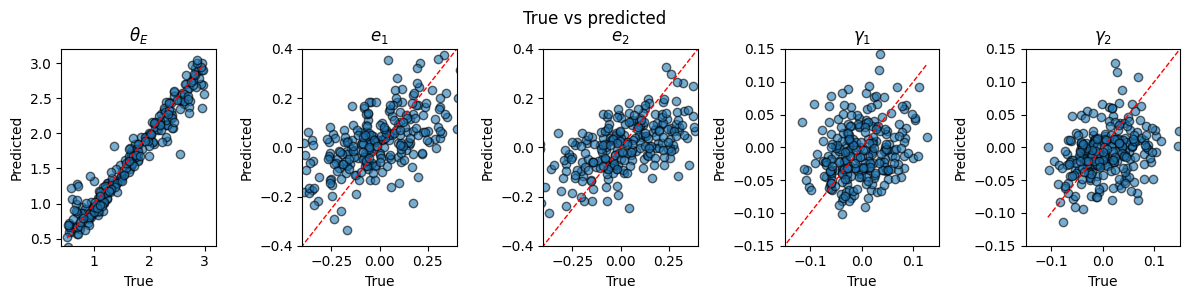

In [17]:
columns = ['theta_e', 'e1', 'e2','shear1', 'shear2']
latex_labels = ['$θ_E$', '$e_1$', '$e_2$', '$\gamma_1$', '$\gamma_2$']

limits = [(0.4, 3.2),
          (-0.4, 0.4),
          (-0.4, 0.4),
          (-0.15, 0.15),
          (-0.15, 0.15)]


fig, axes = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle("True vs predicted")

for i, col in enumerate(columns):
    row = i // 5
    col_number = i % 5
    ax = axes[col_number]
    ax.scatter(results[col + "_true"], results[col + "_pred"], ec='k', alpha=0.6)
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.set_title(latex_labels[i])
    ax.set_xlim(limits[i])
    ax.set_ylim(limits[i])
    ax.plot([min(results[col + "_true"]), max(results[col + "_true"])], [min(results[col + "_true"]), max(results[col + "_true"])], color='red', linestyle='--', lw=1)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


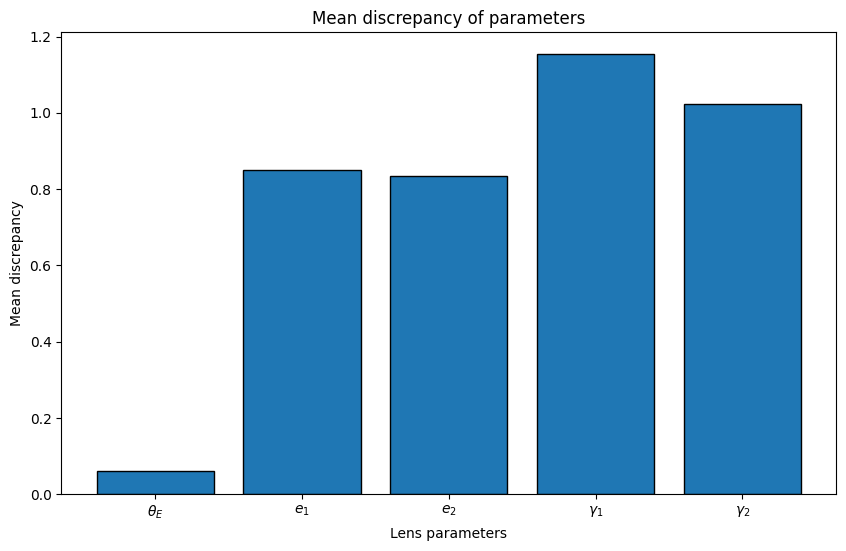

In [18]:
discrepancy_means = []
for col in columns:
    true_col = col + "_true"
    pred_col = col + "_pred"
    mean_discrepancy = abs((results[true_col] - results[pred_col])/results[true_col]).median()
    discrepancy_means.append(mean_discrepancy)

plt.figure(figsize=(10, 6))
plt.bar(latex_labels, discrepancy_means, ec='k')
plt.xlabel('Lens parameters')
plt.ylabel('Mean discrepancy')
plt.title('Mean discrepancy of parameters')
plt.show()
